In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt

import gc
import time
import datetime 
from datetime import timedelta


from VGG_BN import VGG_BN
from utils import count_trainable_parameters, count_total_parameters
from utils import clear_gpu_memory, get_gpu_memory
from utils import plot_metrics, create_summary_table
from utils import get_device, get_dataloaders
from utils import train_one_epoch, evaluate

In [2]:
def load_dataset_metrics(dataset):
    metrics = {
        'train_acc': {},
        'test_acc': {},
        'train_loss': {},
        'test_loss': {},
    }
    for arch in architectures:
        for mode in modes:
            filename = f"{dataset}_{arch}_bottleneck_{mode}_metrics.csv"
            path = os.path.join(results_dir, filename)
            if os.path.exists(path):
                df = pd.read_csv(path)
                label = f"{arch}_{mode}"
                metrics['train_acc'][label] = df['train_acc']
                metrics['test_acc'][label] = df['test_acc']
                metrics['train_loss'][label] = df['train_loss']
                metrics['test_loss'][label] = df['test_loss']
    return metrics

In [3]:
def get_model(arch, num_classes, device, dataset='cifar10', pretrained=False):
    model = VGG_BN(arch, num_classes=num_classes, dataset=dataset)
    return model.to(device)


In [4]:
device = get_device()
print(f'device - {device}')

architectures = ['vgg16', 'vgg19']
modes = ['scratch']  
# modes = ['scratch', 'transfer']  

# batch_size = 8
batch_size = 128
results_dir = 'vgg_bottleneck_results'
os.makedirs(results_dir, exist_ok=True)

clear_gpu_memory()
get_gpu_memory()


epochs = 20
dataset_name = "mnist"
trainloader, testloader, num_classes = get_dataloaders(dataset_name, batch_size)


device - cuda
GPU memory allocated: 0.00 GB
GPU memory reserved: 0.00 GB


In [5]:
now = datetime.datetime.now()
now.strftime('%Y-%m-%dT%H:%M:%S') + ('-%02d' % (now.microsecond / 10000))

'2025-04-29T10:53:30-33'

In [6]:

for arch in architectures:
    for mode in modes:
        use_pretrained = (mode == 'transfer')

        print(f"\n{mode.title()} learning: {arch} on {dataset_name}...")
        print("="*50)

        total_train_time = 0
        total_eval_time = 0
        start_time = time.time()

        #  get_model(arch, num_classes, device, dataset='cifar10', pretrained=False):
        model = get_model(arch, num_classes, device, dataset=dataset_name, pretrained=use_pretrained)
        criterion = nn.CrossEntropyLoss()
            
        optimizer = optim.SGD(
            model.parameters(),
            lr=0.01,
            momentum=0.9,
            weight_decay=5e-4
        )

        trainable = count_trainable_parameters(model)
        total = count_total_parameters(model)
        print(f"Trainable parameters: {trainable:,}")
        print(f"Total parameters: {total:,}")
        print(f"Percentage trainable: {trainable/total:.2%}")

        history = []
        for epoch in range(1, epochs + 1):
            epoch_start = time.time()
            
            train_start = time.time()
            train_loss, train_acc = train_one_epoch(model, trainloader, criterion, optimizer, device)
            train_time = time.time() - train_start
            
            eval_start = time.time()
            test_loss, test_acc = evaluate(model, testloader, criterion, device)
            eval_time = time.time() - eval_start
            
            total_train_time += train_time
            total_eval_time += eval_time
            epoch_time = time.time() - epoch_start

            now = datetime.datetime.now()
            now.strftime('%Y-%m-%dT%H:%M:%S') + ('-%02d' % (now.microsecond / 10000))
            
            print(f"Epoch {epoch}/{epochs} - "
                  f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, "
                  f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")
            print(f"Epoch time: {timedelta(seconds=epoch_time)} "
                  f"(Train: {timedelta(seconds=train_time)}, "
                  f"Eval: {timedelta(seconds=eval_time)}.n"
                  f"Timestamp: {now}"
                 )
                
            history.append({
                'epoch': epoch,
                'train_loss': train_loss,
                'train_acc': train_acc,
                'test_loss': test_loss,
                'test_acc': test_acc,
                'train_time': train_time,
                'eval_time': eval_time,
                'epoch_time': epoch_time,
                'Timestamp': now,
            })


        total_time = time.time() - start_time
        avg_epoch_time = total_time / epochs
        avg_train_time = total_train_time / epochs
        avg_eval_time = total_eval_time / epochs
        
        print("\nTraining Summary:")
        print(f"Total training time: {timedelta(seconds=total_time)}")
        print(f"Average epoch time: {timedelta(seconds=avg_epoch_time)}")
        print(f"Average training time per epoch: {timedelta(seconds=avg_train_time)}")
        print(f"Average evaluation time per epoch: {timedelta(seconds=avg_eval_time)}")
        print(f"Total training time (excluding eval): {timedelta(seconds=total_train_time)}")
        print(f"Total evaluation time: {timedelta(seconds=total_eval_time)}")
            
        # save metrics with timing information
        csv_name = f"{dataset_name}_{arch}_bottleneck_{mode}_metrics.csv"
        df = pd.DataFrame(history)
        df.to_csv(os.path.join(results_dir, csv_name), index=False)
        print(f"\nSaved metrics to {results_dir}/{csv_name}")

        # save model
        model_filename = f"{dataset_name}_bottleneck_{arch}_{mode}_model.pth"
        model_path = os.path.join(results_dir, model_filename)
        torch.save(model.state_dict(), model_path)
        print(f"Saved model weights to {model_path}")

        clear_gpu_memory()
        get_gpu_memory()


Scratch learning: vgg16 on mnist...
Trainable parameters: 6,103,578
Total parameters: 6,103,578
Percentage trainable: 100.00%
Epoch 1/20 - Train loss: 0.1211, Train acc: 0.9644, Test loss: 0.0421, Test acc: 0.9871
Epoch time: 0:00:25.554917 (Train: 0:00:23.366941, Eval: 0:00:02.187965.nTimestamp: 2025-04-29 10:53:56.201030
Epoch 2/20 - Train loss: 0.0270, Train acc: 0.9917, Test loss: 0.0434, Test acc: 0.9864
Epoch time: 0:00:25.083623 (Train: 0:00:22.901115, Eval: 0:00:02.182507.nTimestamp: 2025-04-29 10:54:21.284745
Epoch 3/20 - Train loss: 0.0151, Train acc: 0.9954, Test loss: 0.0292, Test acc: 0.9907
Epoch time: 0:00:25.181587 (Train: 0:00:23.030955, Eval: 0:00:02.150631.nTimestamp: 2025-04-29 10:54:46.466419
Epoch 4/20 - Train loss: 0.0099, Train acc: 0.9971, Test loss: 0.0280, Test acc: 0.9899
Epoch time: 0:00:25.047018 (Train: 0:00:22.873727, Eval: 0:00:02.173290.nTimestamp: 2025-04-29 10:55:11.513524
Epoch 5/20 - Train loss: 0.0068, Train acc: 0.9981, Test loss: 0.0257, Test a

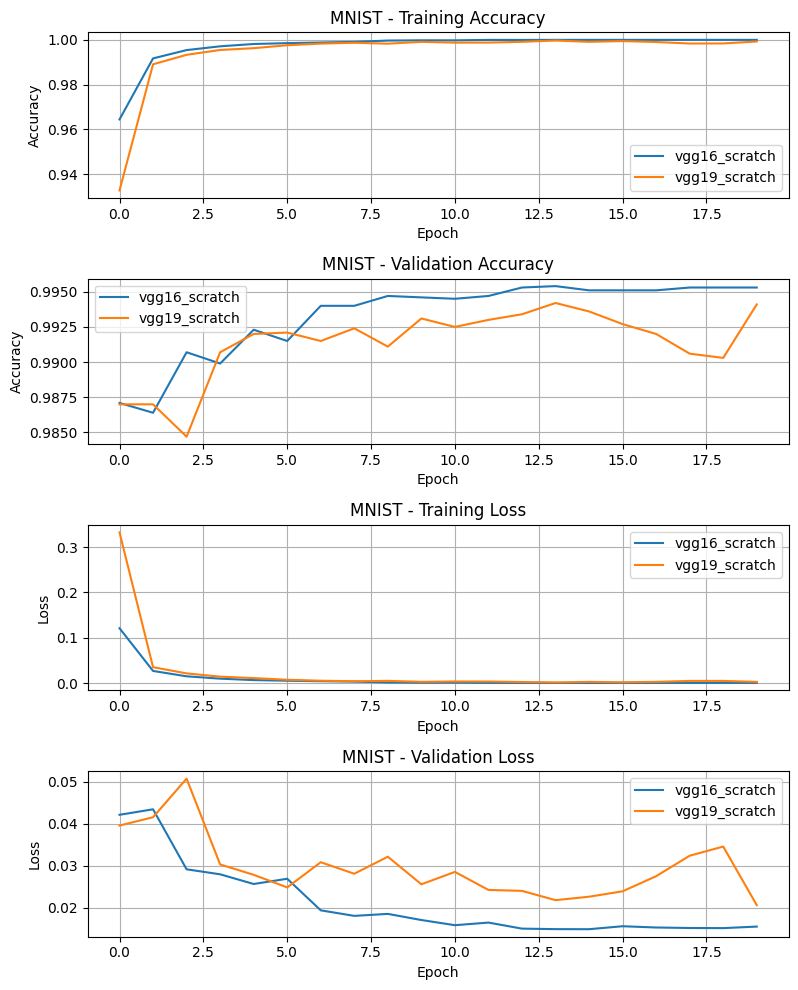

In [7]:
epochs = 20
dataset_name = "mnist"
metrics = load_dataset_metrics(dataset_name)
plot_metrics(metrics, dataset_name, range(epochs))


In [8]:
def create_summary_table(dataset_name="mnist", architectures=[], modes=[], results_dir=""):
    summary_rows = []
 
    for arch in architectures:
        for mode in modes:
            filename = f"{dataset_name}_{arch}_bottleneck_{mode}_metrics.csv"

            path = os.path.join(results_dir, filename)

            if os.path.exists(path):
                df = pd.read_csv(path)
                final = df.iloc[-1]
                best = df.loc[df['test_acc'].idxmax()]
                summary_rows.append({
                    'Dataset': dataset_name.upper(),
                    'Model': arch,
                    'Mode': mode,
                    'Final Train Acc': round(final['train_acc'], 4),
                    'Final Test Acc': round(final['test_acc'], 4),
                    'Final Test Loss': round(final['test_loss'], 4),
                    'Best Epoch': int(best['epoch']),
                    'Best Test Acc': round(best['test_acc'], 4),
                })
    return pd.DataFrame(summary_rows)


In [9]:
summary_df = create_summary_table(dataset_name=dataset_name, 
                                  architectures=architectures,
                                 modes=modes,
                                 results_dir=results_dir)
print(summary_df.to_string(index=False))

Dataset Model    Mode  Final Train Acc  Final Test Acc  Final Test Loss  Best Epoch  Best Test Acc
  MNIST vgg16 scratch           1.0000          0.9953           0.0156          14         0.9954
  MNIST vgg19 scratch           0.9993          0.9941           0.0207          14         0.9942


## cifar10

In [10]:
epochs = 20
dataset_name = "cifar10"
trainloader, testloader, num_classes = get_dataloaders(dataset_name, batch_size)

for arch in architectures:
    for mode in modes:
        use_pretrained = (mode == 'transfer')

        print(f"\n{mode.title()} learning: {arch} on {dataset_name}...")
        print("="*50)

        total_train_time = 0
        total_eval_time = 0
        start_time = time.time()
            
        model = get_model(arch, num_classes, device, dataset=dataset_name, pretrained=use_pretrained)
        criterion = nn.CrossEntropyLoss()
            
        optimizer = optim.SGD(
            model.parameters(),
            lr=0.01,
            momentum=0.9,
            weight_decay=5e-4
        )

        trainable = count_trainable_parameters(model)
        total = count_total_parameters(model)
        print(f"Trainable parameters: {trainable:,}")
        print(f"Total parameters: {total:,}")
        print(f"Percentage trainable: {trainable/total:.2%}")

        history = []
        for epoch in range(1, epochs + 1):
            epoch_start = time.time()
            
            train_start = time.time()
            train_loss, train_acc = train_one_epoch(model, trainloader, criterion, optimizer, device)
            train_time = time.time() - train_start
            
            eval_start = time.time()
            test_loss, test_acc = evaluate(model, testloader, criterion, device)
            eval_time = time.time() - eval_start
            
            total_train_time += train_time
            total_eval_time += eval_time
            epoch_time = time.time() - epoch_start

            now = datetime.datetime.now()
            now.strftime('%Y-%m-%dT%H:%M:%S') + ('-%02d' % (now.microsecond / 10000))
            
            print(f"Epoch {epoch}/{epochs} - "
                  f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, "
                  f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")
            print(f"Epoch time: {timedelta(seconds=epoch_time)} "
                  f"(Train: {timedelta(seconds=train_time)}, "
                  f"Eval: {timedelta(seconds=eval_time)}, "
                  f"Timestamp: {now}"
                 )
                
            # print(f"Epoch {epoch}/{epochs} - "
            #       f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, "
            #       f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")
            # print(f"Epoch time: {timedelta(seconds=epoch_time)} "
            #       f"(Train: {timedelta(seconds=train_time)}, "
            #       f"Eval: {timedelta(seconds=eval_time)}")
                
            history.append({
                'epoch': epoch,
                'train_loss': train_loss,
                'train_acc': train_acc,
                'test_loss': test_loss,
                'test_acc': test_acc,
                'train_time': train_time,
                'eval_time': eval_time,
                'epoch_time': epoch_time,
                'Timestamp': now,
            })


        total_time = time.time() - start_time
        avg_epoch_time = total_time / epochs
        avg_train_time = total_train_time / epochs
        avg_eval_time = total_eval_time / epochs
        
        print("\nTraining Summary:")
        print(f"Total training time: {timedelta(seconds=total_time)}")
        print(f"Average epoch time: {timedelta(seconds=avg_epoch_time)}")
        print(f"Average training time per epoch: {timedelta(seconds=avg_train_time)}")
        print(f"Average evaluation time per epoch: {timedelta(seconds=avg_eval_time)}")
        print(f"Total training time (excluding eval): {timedelta(seconds=total_train_time)}")
        print(f"Total evaluation time: {timedelta(seconds=total_eval_time)}")
            
        # save metrics with timing information
        csv_name = f"{dataset_name}_{arch}_bottleneck_{mode}_metrics.csv"
        df = pd.DataFrame(history)
        df.to_csv(os.path.join(results_dir, csv_name), index=False)
        print(f"\nSaved metrics to {results_dir}/{csv_name}")

        # save model
        model_filename = f"{dataset_name}_bottleneck_{arch}_{mode}_model.pth"
        model_path = os.path.join(results_dir, model_filename)
        torch.save(model.state_dict(), model_path)
        print(f"Saved model weights to {model_path}")

        clear_gpu_memory()
        get_gpu_memory()


Scratch learning: vgg16 on cifar10...
Trainable parameters: 6,103,578
Total parameters: 6,103,578
Percentage trainable: 100.00%
Epoch 1/20 - Train loss: 1.2352, Train acc: 0.5529, Test loss: 1.0658, Test acc: 0.6188
Epoch time: 0:00:21.354197 (Train: 0:00:19.263895, Eval: 0:00:02.090300, Timestamp: 2025-04-29 11:09:53.682058
Epoch 2/20 - Train loss: 0.7939, Train acc: 0.7185, Test loss: 0.8593, Test acc: 0.7059
Epoch time: 0:00:16.758335 (Train: 0:00:15.125924, Eval: 0:00:01.632409, Timestamp: 2025-04-29 11:10:10.440484
Epoch 3/20 - Train loss: 0.6162, Train acc: 0.7837, Test loss: 0.6671, Test acc: 0.7665
Epoch time: 0:00:15.913514 (Train: 0:00:14.281276, Eval: 0:00:01.632236, Timestamp: 2025-04-29 11:10:26.354084
Epoch 4/20 - Train loss: 0.5080, Train acc: 0.8216, Test loss: 0.6344, Test acc: 0.7836
Epoch time: 0:00:15.919306 (Train: 0:00:14.287795, Eval: 0:00:01.631509, Timestamp: 2025-04-29 11:10:42.273477
Epoch 5/20 - Train loss: 0.4234, Train acc: 0.8553, Test loss: 0.6386, Test

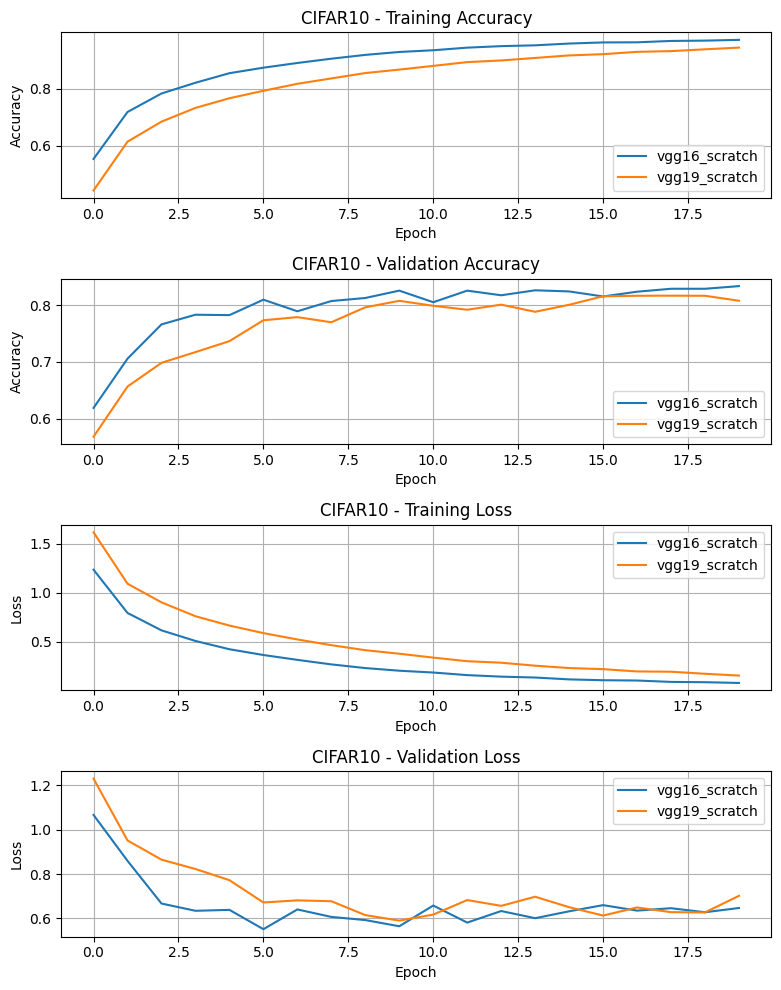

Dataset Model    Mode  Final Train Acc  Final Test Acc  Final Test Loss  Best Epoch  Best Test Acc
CIFAR10 vgg16 scratch           0.9728          0.8342           0.6470          20         0.8342
CIFAR10 vgg19 scratch           0.9455          0.8083           0.7019          18         0.8173


In [11]:
epochs = 20
dataset_name = "cifar10"
metrics = load_dataset_metrics(dataset_name)
plot_metrics(metrics, dataset_name, range(epochs))

# summary_df = create_summary_table(dataset_name=dataset_name)
summary_df = create_summary_table(dataset_name=dataset_name, 
                                  architectures=architectures,
                                 modes=modes,
                                 results_dir=results_dir)
print(summary_df.to_string(index=False))

In [12]:
results_dir

'vgg_bottleneck_results'